Train: (140, 34020)
Test: (20, 34020)
Validation: (20, 34020)


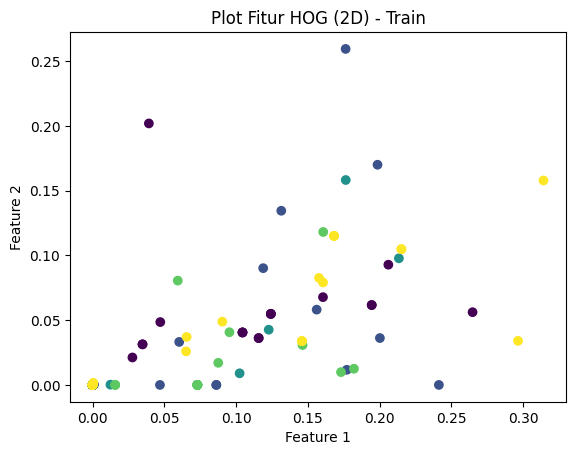

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

BASE = r"dataset/data_rupiah"

def load_images_with_label(path):
  data = []
  labels = []
  for label in os.listdir(path):
    folder = os.path.join(path, label)
    if not os.path.isdir(folder):
      continue
    for f in glob.glob(os.path.join(folder, "*.jpg")):
      img = cv2.imread(f)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img, (128, 128))

      hog = cv2.HOGDescriptor()
      h = hog.compute(img).flatten()

      data.append(h)
      labels.append(int(label))

  return np.array(data), np.array(labels)

train_x, train_y = load_images_with_label(os.path.join(BASE, "train"))
test_x, test_y = load_images_with_label(os.path.join(BASE, "test"))
val_x, val_y = load_images_with_label(os.path.join(BASE, "validation"))

print("Train:", train_x.shape)
print("Test:", test_x.shape)
print("Validation:", val_x.shape)

plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y, cmap='viridis')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Plot Fitur HOG (2D) - Train")
plt.show()

Jumlah koin terdeteksi : 8
Total fitur yang diekstrak : 8
Dimensi fitur HOG per koin : (34020,)


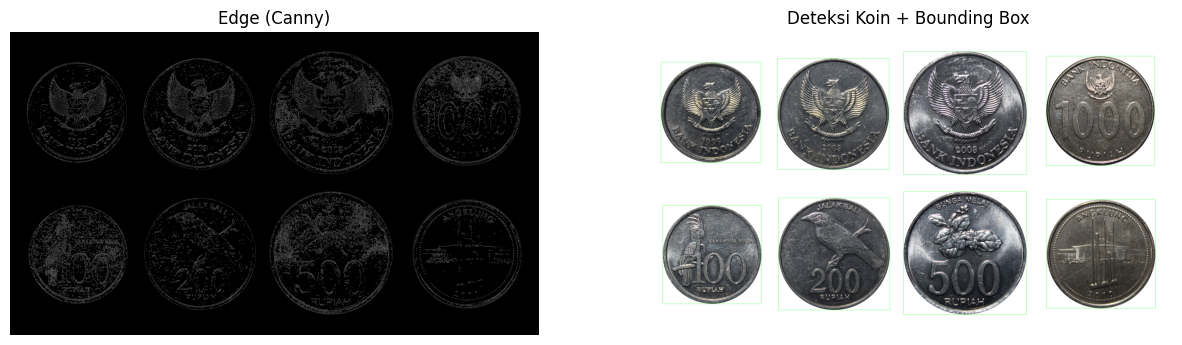

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ekstraksi fitur HOG pada ROI gambar
def extract_hog_feature(roi):
  hog = cv2.HOGDescriptor()
  roi_resized = cv2.resize(roi, (128, 128))  # standard size
  feature = hog.compute(roi_resized).flatten()
  return feature

def detect_coins_with_features(image_path):
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # blur untuk stabilisasi tepi
  blur = cv2.GaussianBlur(gray, (5, 5), 1)

  # edge detection
  edges = cv2.Canny(blur, 60, 150)

  # dilasi untuk menyambungkan tepi
  kernel = np.ones((3, 3), np.uint8)
  dilated = cv2.dilate(edges, kernel, iterations=2)

  # cari kontur
  contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  coin_features = []  # menampung fitur setiap koin
  count = 0

  for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 500:
      continue

    x, y, w, h = cv2.boundingRect(cnt)

    # draw bounding box
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # ambil ROI (bagian koin)
    roi = gray[y:y+h, x:x+w]

    # ekstraksi fitur HOG
    feat = extract_hog_feature(roi)
    coin_features.append(feat)

    count += 1

  return img, edges, coin_features, count

# contoh penggunaan
input_path = r"tests/test1.png"
result_img, edges_img, features, total = detect_coins_with_features(input_path)

print("Jumlah koin terdeteksi :", total)
print("Total fitur yang diekstrak :", len(features))
print("Dimensi fitur HOG per koin :", features[0].shape if total > 0 else "No coin")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Edge (Canny)")
plt.imshow(edges_img, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Deteksi Koin + Bounding Box")
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()


Melatih model...
Training selesai.
Training selesai.
Jumlah koin terdeteksi : 8
Detail prediksi:
  Koin @(273,2548) ukuran 1451x1446 → 82 rupiah
  Koin @(5908,2458) ukuran 1599x1602 → 85 rupiah
  Koin @(1973,2438) ukuran 1636x1646 → 83 rupiah
  Koin @(3809,2345) ukuran 1806x1807 → 84 rupiah
  Koin @(247,444) ukuran 1469x1476 → 81 rupiah
  Koin @(1959,387) ukuran 1638x1635 → 81 rupiah
  Koin @(5902,354) ukuran 1593x1609 → 85 rupiah
  Koin @(3809,286) ukuran 1808x1808 → 81 rupiah
Jumlah koin terdeteksi : 8
Detail prediksi:
  Koin @(273,2548) ukuran 1451x1446 → 82 rupiah
  Koin @(5908,2458) ukuran 1599x1602 → 85 rupiah
  Koin @(1973,2438) ukuran 1636x1646 → 83 rupiah
  Koin @(3809,2345) ukuran 1806x1807 → 84 rupiah
  Koin @(247,444) ukuran 1469x1476 → 81 rupiah
  Koin @(1959,387) ukuran 1638x1635 → 81 rupiah
  Koin @(5902,354) ukuran 1593x1609 → 85 rupiah
  Koin @(3809,286) ukuran 1808x1808 → 81 rupiah


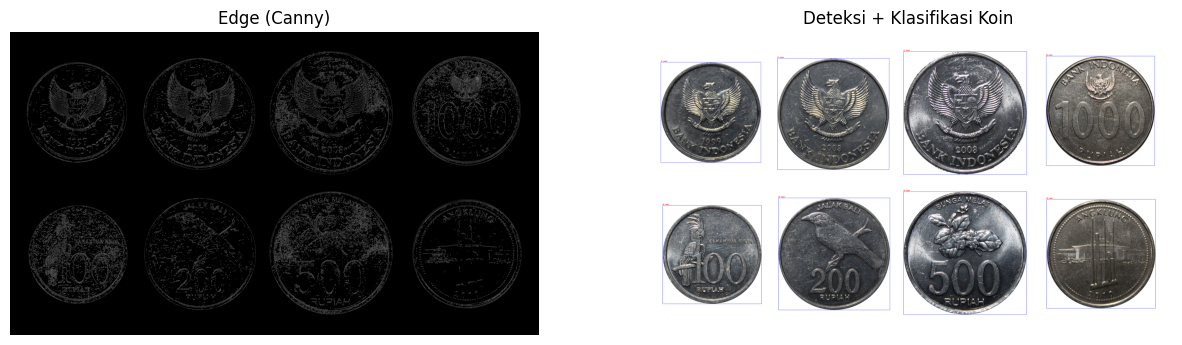

In [26]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# --- TRAINING MODEL ---
print("Melatih model...")

clf = make_pipeline(
  StandardScaler(),
  SVC(kernel='linear', probability=True)
)

clf.fit(train_x, train_y)
print("Training selesai.")

# --- KLASIFIKASI KOIN PADA INPUT ---
def classify_coins_in_image(image_path, model):
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  blur = cv2.GaussianBlur(gray, (5, 5), 1)
  edges = cv2.Canny(blur, 60, 150)

  kernel = np.ones((3, 3), np.uint8)
  dilated = cv2.dilate(edges, kernel, iterations=2)

  contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  predictions = []

  for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 500:
      continue

    x, y, w, h = cv2.boundingRect(cnt)
    roi = gray[y:y+h, x:x+w]

    # ekstraksi fitur HOG
    feat = extract_hog_feature(roi).reshape(1, -1)

    # prediksi nilai koin
    pred = model.predict(feat)[0]

    predictions.append((x, y, w, h, pred))

    # gambar bounding box + label
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.putText(img, f"{pred} rupiah",
                (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                0.6, (0, 0, 255), 2)

  return img, edges, predictions

# --- TEST ---
input_path = r"tests/test1.png"
final_img, edge_img, detected = classify_coins_in_image(input_path, clf)

print("Jumlah koin terdeteksi :", len(detected))
print("Detail prediksi:")
for (x, y, w, h, pred) in detected:
  print(f"  Koin @({x},{y}) ukuran {w}x{h} → {pred} rupiah")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Edge (Canny)")
plt.imshow(edge_img, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Deteksi + Klasifikasi Koin")
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()
